##### Template by Nicholas Renotte, GitHub nicknochnack

# 1. Install Dependencies and Setup

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [39]:
import tensorflow as tf
import os

In [40]:
#to prevent out of memory error
units = tf.config.experimental.list_physical_devices('GPU')
for unit in units:
    tf.config.experimental.set_memory_growth(unit, True)

# 2. Remove dodgy images

In [41]:
import cv2
import imghdr

In [42]:
data_dir = 'data'

In [43]:
image_exits = ['jpeg','jpg', 'png']

In [ ]:
#checking folder directory and data in folder -> success
#os.listdir(data_dir)
#os.listdir(os.path.join(data_dir, 'patients'))

In [44]:
#cleaning up dodgy imgs
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exits:
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [45]:
import numpy as np
from matplotlib import pyplot as plt

In [46]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 211 files belonging to 2 classes.


In [47]:
data_iterator = data.as_numpy_iterator()

In [48]:
#min 0 and max 1
batch = data_iterator.next()

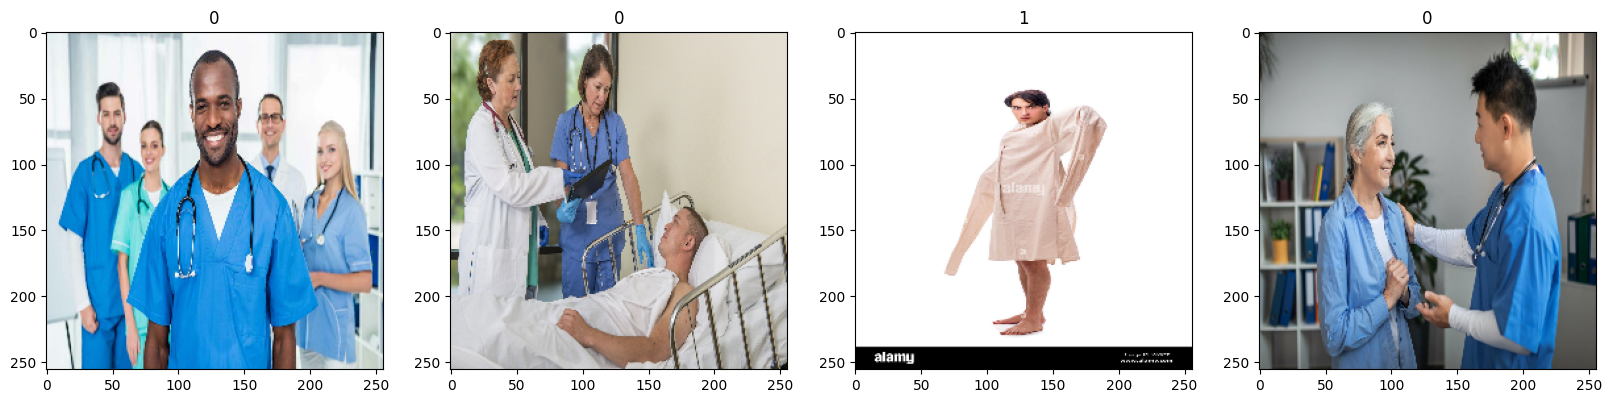

In [49]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [50]:
#x->image, y->label
data = data.map(lambda x,y: (x/255, y))

In [51]:
data.as_numpy_iterator().next()

(array([[[[0.81205577, 0.858678  , 0.7806832 ],
          [0.8196957 , 0.86283296, 0.79859066],
          [0.8233626 , 0.8547343 , 0.7723839 ],
          ...,
          [0.8980392 , 0.8745098 , 0.8196538 ],
          [0.89876324, 0.86768174, 0.824399  ],
          [0.8868566 , 0.8708793 , 0.8238205 ]],
 
         [[0.83093596, 0.8643193 , 0.8032205 ],
          [0.8318091 , 0.8652022 , 0.79708487],
          [0.8191253 , 0.8388072 , 0.752548  ],
          ...,
          [0.89455163, 0.8710682 , 0.82400936],
          [0.90345436, 0.87992495, 0.83286613],
          [0.9015242 , 0.8779948 , 0.83093596]],
 
         [[0.83392394, 0.8770612 , 0.8154786 ],
          [0.82966703, 0.86052907, 0.7935457 ],
          [0.79752946, 0.8267693 , 0.7372549 ],
          ...,
          [0.89942557, 0.87592506, 0.8288705 ],
          [0.8976792 , 0.87472683, 0.827668  ],
          [0.8983277 , 0.8763761 , 0.8293173 ]],
 
         ...,
 
         [[0.73708475, 0.7431892 , 0.7606992 ],
          [0.73923

# 5. Split Data

In [ ]:
#batch number, to be divided
#len(data)

7

In [54]:
#data batches division -> 70% training, 20% validation, 10% testing
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
#train_size
#validation_size
#test_size

In [55]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)

# 6. Build Deep Learning Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [57]:
seq_model = Sequential()

In [58]:
#Deep Learning model layers
#relu -> to convert negative output to 0
#sigmoid -> to get outcome 0 or 1
seq_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
seq_model.add(MaxPooling2D())
seq_model.add(Conv2D(32, (3,3), 1, activation='relu'))
seq_model.add(MaxPooling2D())
seq_model.add(Conv2D(16, (3,3), 1, activation='relu'))
seq_model.add(MaxPooling2D())
seq_model.add(Flatten())
seq_model.add(Dense(256, activation='relu'))
seq_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
#adam keras optimizer
seq_model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
#seq_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [60]:
logdir='logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
histr = seq_model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5573 - loss: 1.0754 - val_accuracy: 0.3750 - val_loss: 0.8673
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3906 - loss: 0.8049 - val_accuracy: 0.6406 - val_loss: 0.6878
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7042 - loss: 0.6804 - val_accuracy: 0.5469 - val_loss: 0.6351
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5990 - loss: 0.6350 - val_accuracy: 0.6406 - val_loss: 0.6047
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.6417 - loss: 0.5869 - val_accuracy: 0.6094 - val_loss: 0.5328
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7115 - loss: 0.5228 - val_accuracy: 0.9219 - val_loss: 0.4408
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8146 - loss: 0.4296 - val_accuracy: 0.9375 - val_loss: 0.3454
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9438 - loss: 0.3075 - val_accuracy: 0.9844 - val_loss: 0.2063
Epoch 9/

# 8. Plot Performance

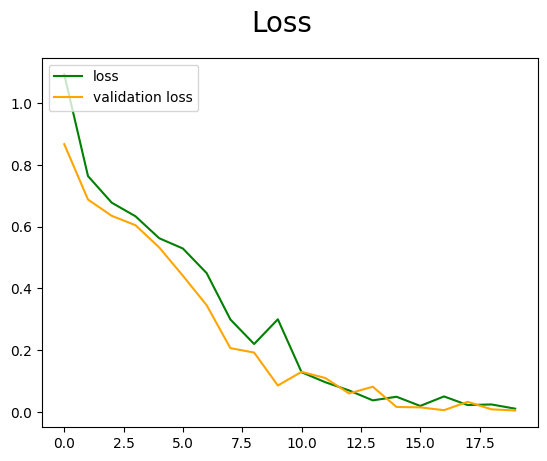

In [63]:
fig = plt.figure()
plt.plot(histr.history['loss'], color='green', label='loss')
plt.plot(histr.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

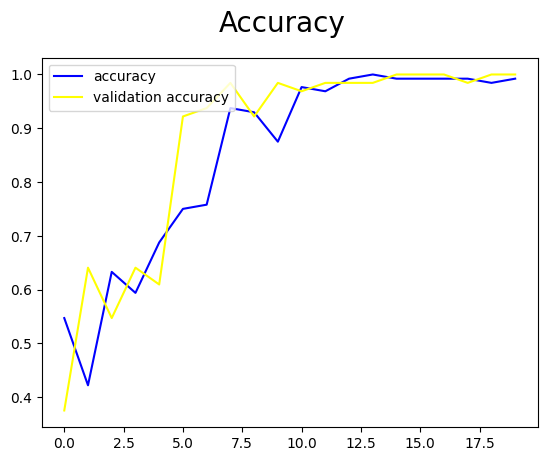

In [64]:
fig = plt.figure()
plt.plot(histr.history['accuracy'], color='blue', label='accuracy')
plt.plot(histr.history['val_accuracy'], color='yellow', label='validation accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [65]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [66]:
precisn = Precision()
recl = Recall()
bi_accuracy = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = seq_model.predict(X)
    precisn.update_state(y, yhat)
    recl.update_state(y, yhat)
    bi_accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


In [69]:
print(f'Presicion: {precisn.result().numpy()}, Recall:{recl.result().numpy()}, Accuracy: {bi_accuracy.result().numpy()}')

Presicion: 1.0, Recall:1.0, Accuracy: 1.0


# 10. Test

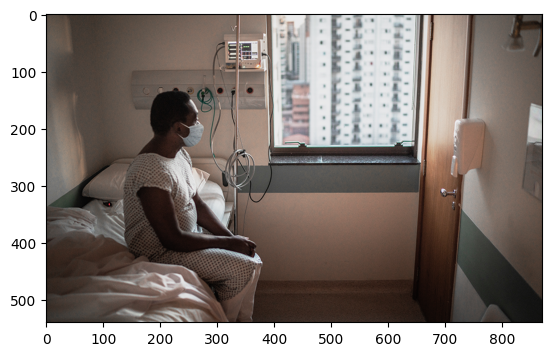

In [86]:
img_patient = cv2.imread(os.path.join(data_dir, 'patient_test.png'))
plt.imshow(cv2.cvtColor(img_patient, cv2.COLOR_BGR2RGB))
plt.show()

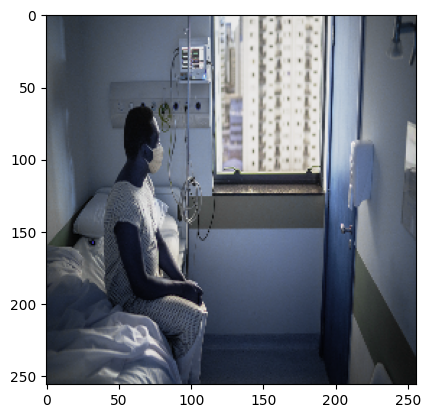

In [94]:
img_resized = tf.image.resize(img_patient, (256,256))
plt.imshow(img_resized.numpy().astype(int))
plt.show()

In [95]:
yhat = seq_model.predict(np.expand_dims(img_resized/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [98]:
#np.expand_dims(img_resized/255, 0).shape

(1, 256, 256, 3)

In [99]:
if yhat < 0.5:
    print(f'Medical personnel')
else:
    print(f'Patient')

Patient


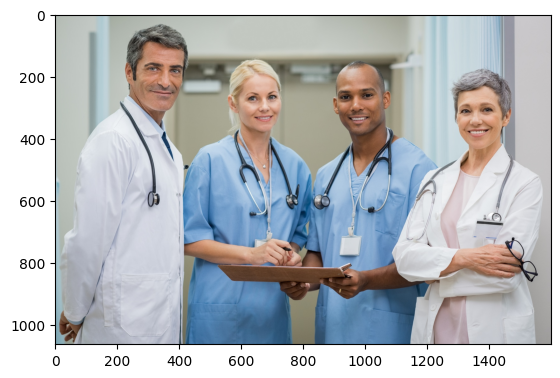

In [113]:
img_doctor = cv2.imread(os.path.join(data_dir, 'doctor_test.jpg'))
plt.imshow(cv2.cvtColor(img_doctor, cv2.COLOR_BGR2RGB))
plt.show()

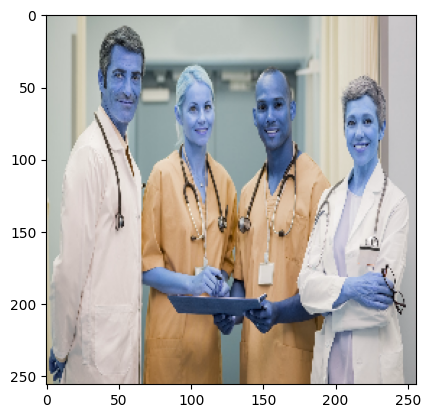

In [119]:
img_resized2 = tf.image.resize(img_doctor, (256,256))
plt.imshow(img_resized2.numpy().astype(int))
plt.show()

In [115]:
yhat2 = seq_model.predict(np.expand_dims(img_resized2/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [103]:
#np.expand_dims(img_resized/255, 0).shape

(1, 256, 256, 3)

In [116]:
if yhat2 < 0.5:
    print(f'Medical personnel')
else:
    print(f'Patient')

Medical personnel


# 11. Save the Model

In [120]:
from tensorflow.keras.models import load_model

In [121]:
seq_model.save(os.path.join('patients_doctors_model.h5'))

In [122]:
new_model = load_model('patients_doctors_model.h5')

In [123]:
new_model.predict(np.expand_dims(img_resized/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[0.7860631]], dtype=float32)